# The goal of this Notebook is to train a classifier that can detect cars in a video stream

In [1]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    #Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                 cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    #Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                 cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):   
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



## Define the function we will use to run through the images

In [2]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [8]:
from sklearn.cross_validation import train_test_split
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
import pdb

#Divide images up into cars and notcars
datafolder = '/media/josealb/HDD_1/Datasets/Self_driving/vehicle_detection/'
images = glob.glob(datafolder+'/*/*/*.*')
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
### Parameters to tweak
colorspace = 'LUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0,1,2 or 'ALL'

t=time.time()
car_features = extract_features(cars,color_space=colorspace, orient=orient,
                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block
                                ,hog_channel=hog_channel)
notcar_features = extract_features(notcars,color_space=colorspace, orient=orient,
                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block
                                ,hog_channel=hog_channel)
t2 = time.time()

print(round(t2-t,2), ' Seconds to extract HOG features...')
#Create an aray stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_Scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_Scaler.transform(X)

#Define the labels vector
y=np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

#Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print ('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:',len(X_train[0]))
# Use a LinearSVC
svc = LinearSVC()
#Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2=time.time()
print(round(t2-t,2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ',round(svc.score(X_test, y_test), 4))

#Check prediction time for a single sample
t=time.time()
n_predict = 10
print ('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print ('For these',n_predict, 'labes: ',y_test[0:n_predict])
t2 = time.time()
print(round(t2-t,5),'Seconds to predict', n_predict, 'labels with SVC')

%mkdir 'models'
with open('models/trained_SVC.p', 'wb') as pickle_file:
    s = pickle.dump(svc,pickle_file)

/home/josealb/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


44.51  Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
10.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9797
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  1.  1.  0.]
For these 10 labes:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
0.00264 Seconds to predict 10 labels with SVC
mkdir: cannot create directory ‘models’: File exists


/home/josealb/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


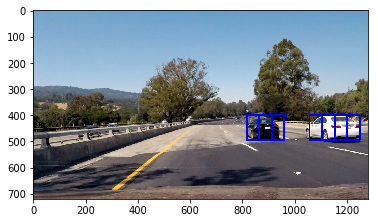

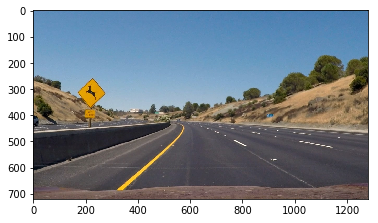

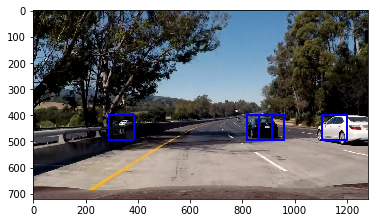

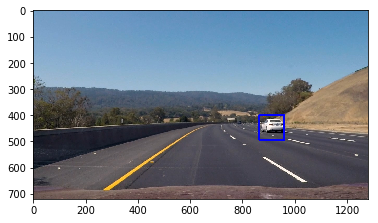

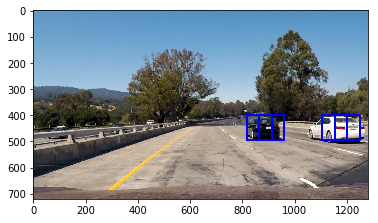

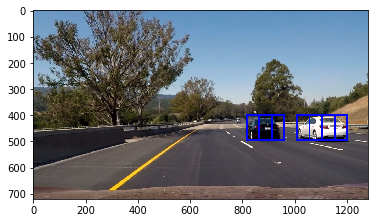

In [9]:
svc = pickle.load( open( 'models/trained_SVC.p', "rb" ) )

color_space='LUV'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
%matplotlib inline

images = glob.glob('test_images/*.jpg')


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
for file in images:
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    y_start_stop = [400, None] # Min and max in y to search in slide_window()

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_Scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    fig = plt.figure()#(figsize=(24,16))
    plt.imshow(window_img)




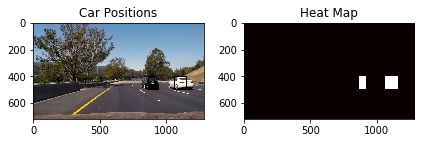

In [10]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = hot_windows

# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [12]:
labels

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)

The classifier does not work correctly, there are a lot of false positives
Since the classifier accuracy was high, let's see whether there is any preparation difference between training data and test data


In [5]:
def show_information(variable,name):
    print('********')
    print('Showing information on: ',name)
    print('Data type: ',type(variable))
    print('Data shape: ', variable.shape)
    print('Data: ',variable)
    print('Mean: ',np.mean(variable))
    print('Min: ',np.min(variable))
    print('Max: ',np.max(variable))
    
show_information(X[0],'Training features before pre-processing')
show_information(X_train[0],'Training features after scaling')
show_information(image,'Test images before pre-processing')
#show_information(processed_image,'Test images after first scaling')


********
Showing information on:  Training features before pre-processing
Data type:  <class 'numpy.ndarray'>
Data shape:  (4932,)
Data:  [ 0.36078432  0.37254903  0.26274511 ...,  0.00741978  0.00804651
  0.00779375]
Mean:  2.65727971177
Min:  0.0
Max:  4096.0
********
Showing information on:  Training features after scaling
Data type:  <class 'numpy.ndarray'>
Data shape:  (4932,)
Data:  [-0.35920975 -0.52308731 -0.3532601  ..., -0.44098937 -0.52250471
 -0.54848998]
Mean:  -0.423036490829
Min:  -1.60446620709
Max:  8.09645509258
********
Showing information on:  Test images before pre-processing
Data type:  <class 'numpy.ndarray'>
Data shape:  (720, 1280, 3)
Data:  [[[ 0.99215686  0.90980393  0.83529413]
  [ 0.94117647  0.90588236  0.87843138]
  [ 0.76862746  0.79607844  0.81960785]
  ..., 
  [ 0.07058824  0.13725491  0.2       ]
  [ 0.08627451  0.14901961  0.21176471]
  [ 0.10588235  0.16862746  0.22745098]]

 [[ 0.95294118  0.90196079  0.87843138]
  [ 0.72941178  0.72549021  0.74509

NameError: name 'processed_image' is not defined